In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sbr
from numpy.random import uniform
import networkx as nx

from sklearn import preprocessing, metrics, model_selection
from statsmodels.api import qqplot_2samples

from scipy.stats import pearsonr, ks_2samp

sbr.set(rc={'figure.figsize':[15, 10]})
plt.rcParams['figure.figsize'] = [15, 10]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower
%matplotlib inline

dataset = pd.read_csv("/home/rami/hdd/multivariable_analysis/kc_house_data.csv")

target = 'price'
predictors = ['sqft_living', 'bedrooms', 'bathrooms', 'grade', 'condition', 'sqft_living15', 'sqft_above', 'sqft_basement']


dataset = dataset.drop(dataset.loc[dataset.price > 3430000.0].index)

data = dataset[ ['price', 'sqft_living', 'bedrooms', 'bathrooms', 'grade', 'condition', 'sqft_living15', 'sqft_above', 'sqft_basement'] ]
data.head()

,price,sqft_living,bedrooms,bathrooms,grade,condition,sqft_living15,sqft_above,sqft_basement
0,221900.0,1180,3,1.00,7,3,1340,1180,0
1,538000.0,2570,3,2.25,7,3,1690,2170,400
2,180000.0,770,2,1.00,6,3,2720,770,0
3,604000.0,1960,4,3.00,7,5,1360,1050,910
4,510000.0,1680,3,2.00,8,3,1800,1680,0


# Sampling

In [78]:
import scipy.interpolate as interpolate

def inverse_transform_sampling(df, n_buckets=100, n_samples=1000):
    
    its_data = dict()
    
    for label in df.columns:
    
        data = df[label]
        
        if data.unique().shape[0] < 100:
            n_bins = np.unique(data)
        else:
            n_bins = n_buckets
        
        hist, bin_edges = np.histogram(data, bins=n_bins, density=True)
        cum_values = np.zeros(bin_edges.shape)
        cum_values[1:] = np.cumsum(hist*np.diff(bin_edges))
        inv_cdf = interpolate.interp1d(cum_values, bin_edges)
        r = np.random.rand(n_samples)
        
        its_data[label] = inv_cdf(r)
    
    res = pd.DataFrame(its_data)
        
    return res

def geometric_transform_sampling(df, n_buckets=100, n_samples=1000):
    
    gts_data = dict()
    
    for label in df.columns:
        
        data = df[label]
        
        if data.unique().shape[0] < 100:
            n_bins = np.unique(data)
        else:
            n_bins = n_buckets

        counts, buckets = np.histogram(data, bins=n_bins, density=True)

        low_h, upper_h = np.min(buckets), np.max(buckets)
        low_v, upper_v = np.min(counts), np.max(counts)

        samples = []

        while len(samples) < n_samples:

            x_candidates = uniform(low_h, upper_h, size=1000)
            y_candidates = uniform(low_v, upper_v, size=1000)

            idxs = np.digitize(x_candidates, buckets) - 1
            approved_mask = (y_candidates <= counts[idxs])
            
            samples.extend(x_candidates[approved_mask])

        gts_data[label] = samples[:n_samples]

    res = pd.DataFrame(gts_data)
    return res

def plot_hists(init_df, df, tf_type):
    
    for label in df.columns:
        
        if data[label].unique().shape[0] < 100:
            n_bins = np.unique(data[label])
        else:
            n_bins = 100
        
        plt.hist(init_df[label], density=True, bins=n_bins, alpha=0.5, label='raw data')
        plt.hist(df[label], density=True, bins=n_bins, alpha=0.5, label=f'{tf_type} data')
        
        plt.title(label)
        plt.legend(loc='best')
        plt.show()
        
        
def plot_qq(init_df, df, tf_type):
    
    for label in df.columns:
        
        init_distribution, buckets = np.histogram(init_df[label], density=True)
        its_distribution, buckets = np.histogram(df[label], bins=buckets, density=True)
        
        ks = ks_2samp(its_distribution, init_distribution)
        
        qqplot_2samples(init_df[label], df[label], line='45', xlabel=f'{tf_type} distribution', ylabel='Init distribution')
        plt.title(label + ' KS: s=%f, p=%f' % ks)
        plt.show()
        
def plot_stats_side2side(init_df, df, tf_type):
        
    for label in df.columns:
        
        f, axes = plt.subplots(ncols=2, figsize=(13, 5))
        
        init_data = init_df[label]
        tf_data = df[label]
        
        if init_data.unique().shape[0] < 100:
            n_bins = np.unique(init_data)
        else:
            n_bins = 100
        
        init_distribution, buckets = np.histogram(init_df[label], density=True)
        its_distribution, buckets = np.histogram(df[label], bins=buckets, density=True)
        
        ks = ks_2samp(its_distribution, init_distribution)
        
        axes[0].hist(init_data, density=True, bins=n_bins, alpha=0.5, label='raw data')
        axes[0].hist(tf_data, density=True, bins=n_bins, alpha=0.5, label=f'{tf_type} data')
        axes[0].set_xlabel('bins')
        axes[0].set_ylabel('count')
        axes[0].set_title( label + ' KS: s=%f, p=%f' % ks )
        axes[0].legend(loc='best')
        
        qqplot_2samples(init_df[label], df[label], line='45', xlabel=f'{tf_type} distribution', ylabel='Init distribution', ax=axes[1])
        axes[1].set_title(label + ' QQ plot' )

        f.suptitle(f'{tf_type} sampling results', fontsize=16)
        plt.show()

its_data = inverse_transform_sampling(data[predictors], n_buckets=100, n_samples=1000)
plot_hists(data[predictors], its_data, 'ITS')
plot_qq(data[predictors], its_data, 'ITS')

gts_data = geometric_transform_sampling(data[predictors], n_buckets=100, n_samples=1000)
plot_hists(data[predictors], its_data, 'GTS')
plot_qq(data[predictors], its_data, 'GTS')

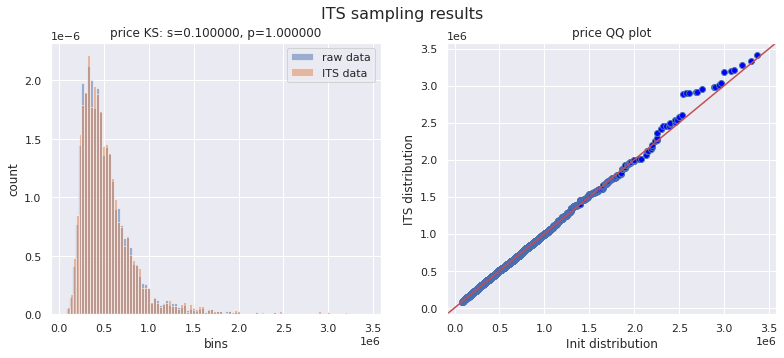

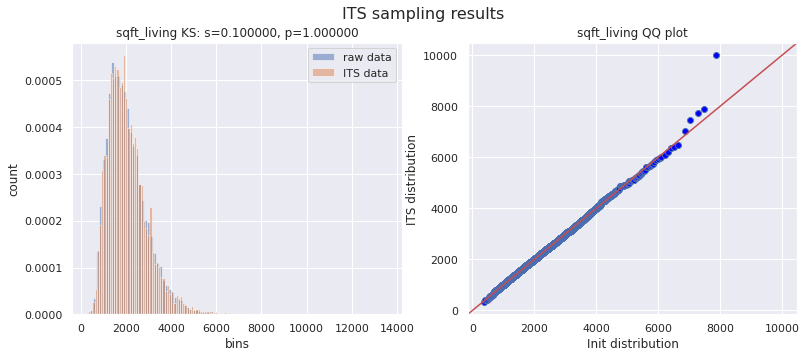

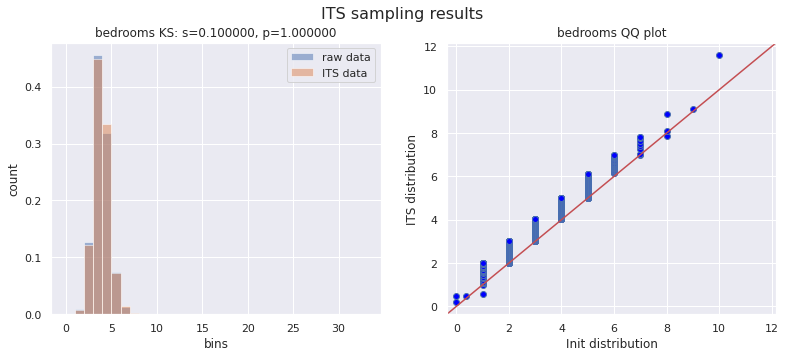

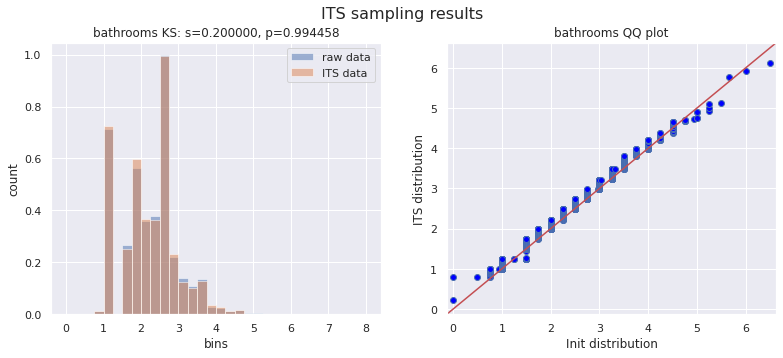

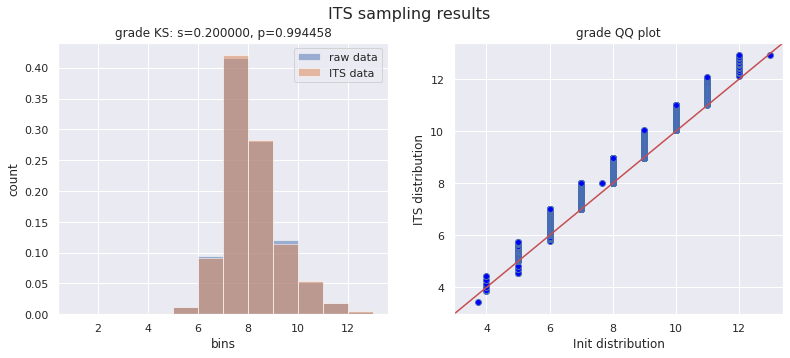

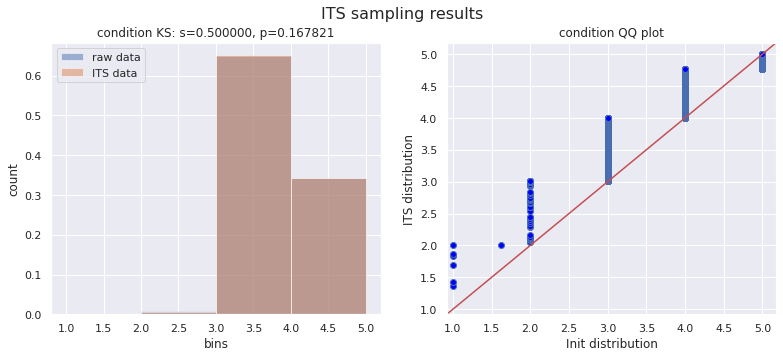

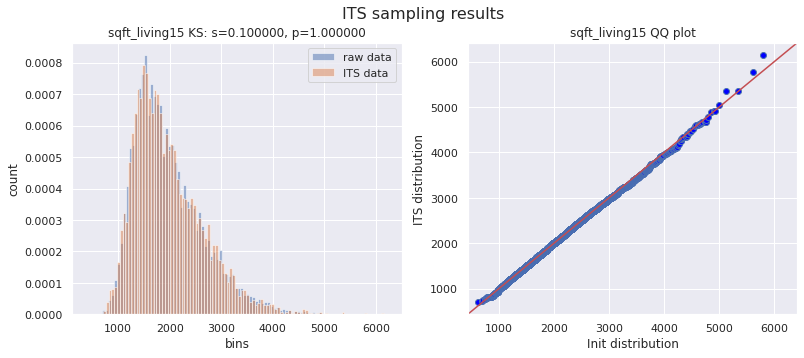

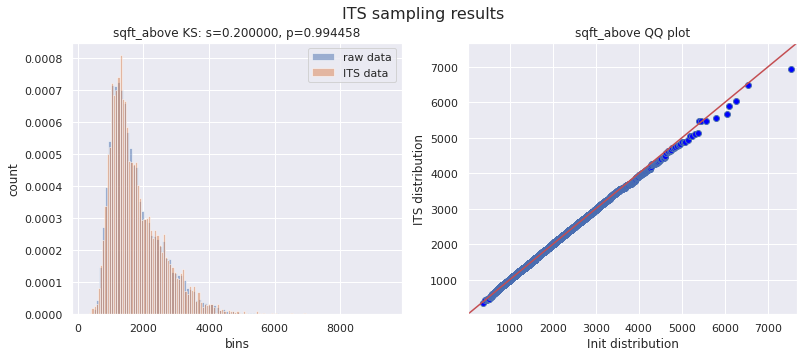

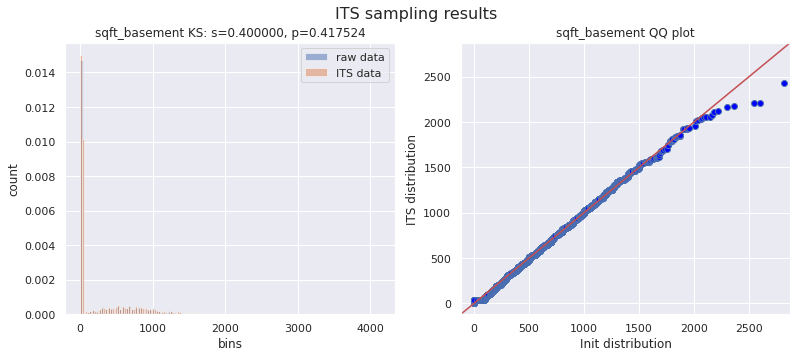

In [80]:
its_data = inverse_transform_sampling(data, n_buckets=100, n_samples=5000)
plot_stats_side2side(data, its_data, 'ITS')

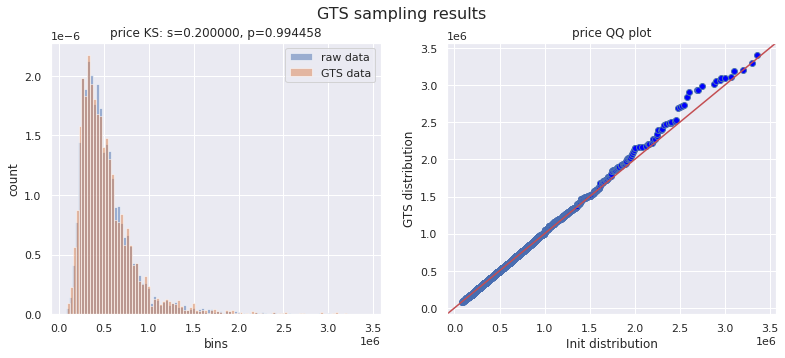

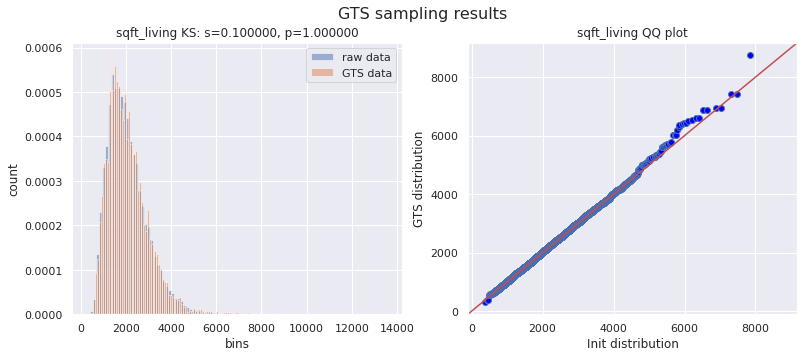

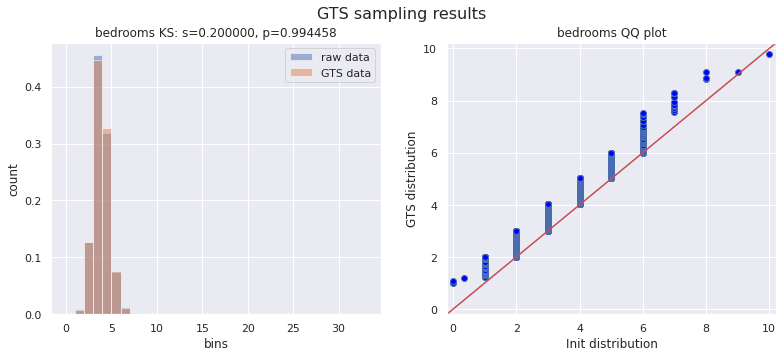

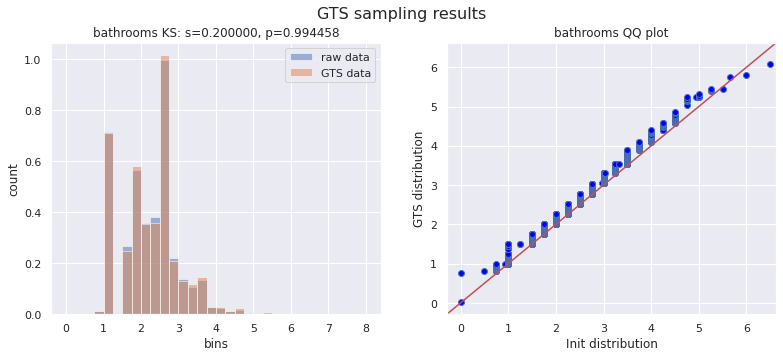

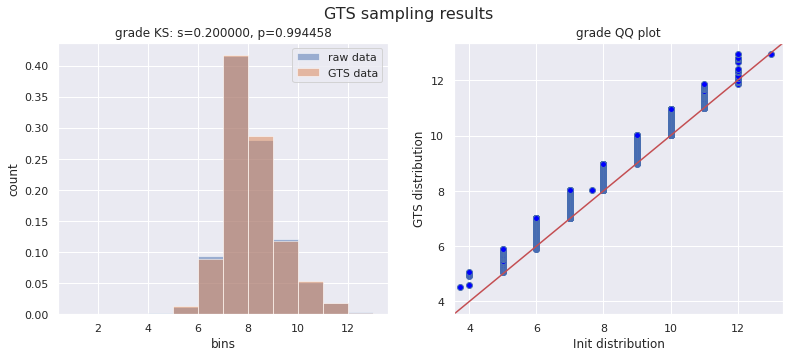

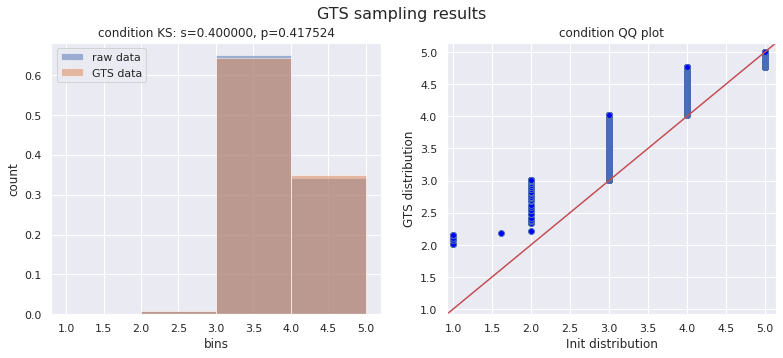

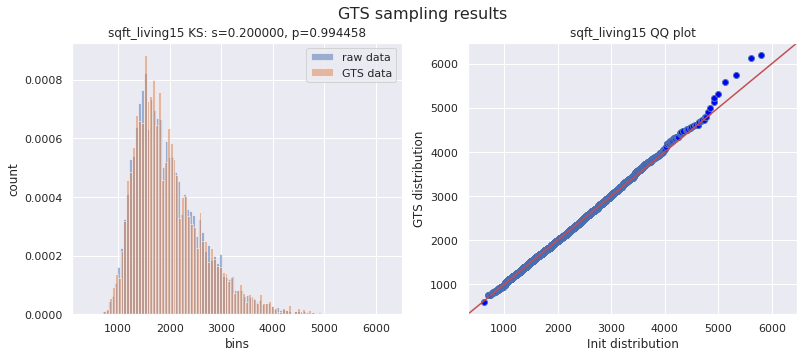

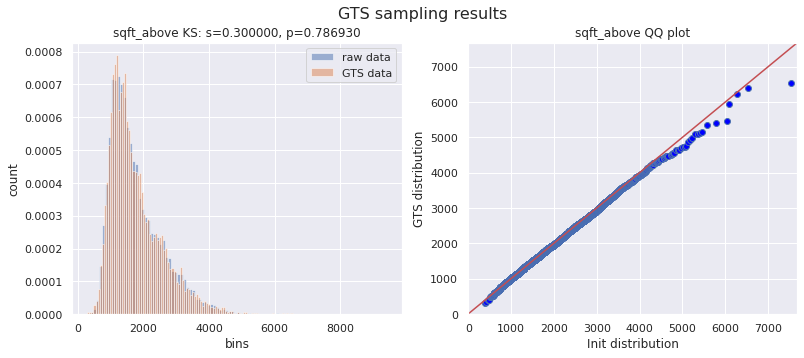

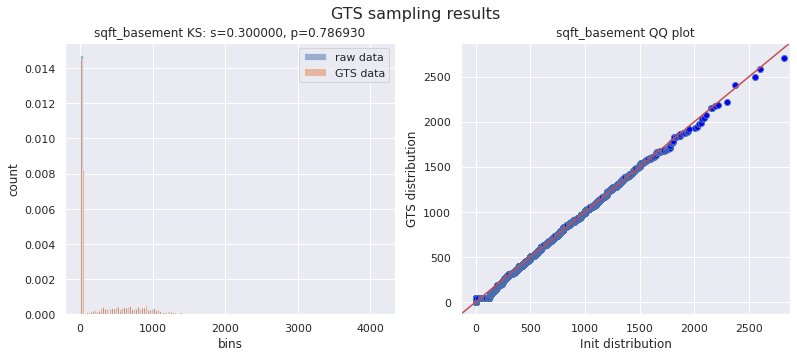

In [81]:
gts_data = geometric_transform_sampling(data, n_buckets=100, n_samples=5000)
plot_stats_side2side(data, gts_data, 'GTS')

# Correlation

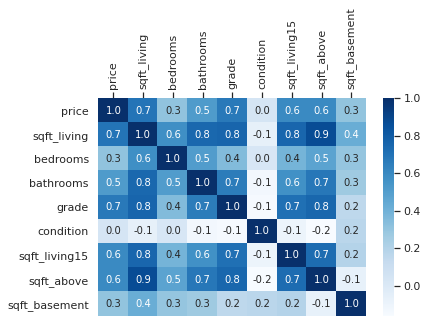

In [5]:
corr = data.corr()
sbr.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, annot=True, fmt='.1f', cmap = 'Blues').xaxis.tick_top()
plt.xticks(rotation=90)
plt.show()

In [36]:
df_disc = data.copy() #its_data.copy()

est = preprocessing.KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='kmeans')
data_t = est.fit_transform(df_disc.values[:, 1:])
df_disc[df_disc.columns[1:]] = data_t

# Bayesian model

In [7]:
from pgmpy.estimators import HillClimbSearch, TreeSearch
from pgmpy.estimators import BDeuScore, K2Score, BicScore
from pgmpy.models import BayesianModel
from pgmpy.sampling import BayesianModelSampling
from pgmpy.inference import VariableElimination
from pgmpy.base import DAG

In [8]:
edges = {
    "bedrooms": ["sqft_living"],
    "bathrooms": ["sqft_living", "price", "bedrooms"],
    "grade": ["bathrooms", "sqft_above", "price"],
    "condition": ["price", "bedrooms"],
    "sqft_living15": ["sqft_living", "grade"],
    "sqft_basement": ["sqft_living"],
    "sqft_above": ["sqft_living"],
    "sqft_living": ["price"],
}

edges_list = []
for out_var, in_vars in edges.items():
    for in_var in in_vars:
        edges_list.append((out_var, in_var))

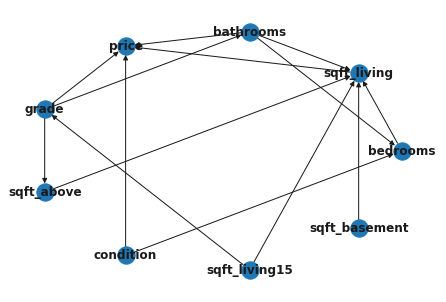

In [9]:
G_custom = nx.DiGraph(edges_list)
pos = nx.layout.circular_layout(G_custom)
nx.draw(G_custom, pos, with_labels=True,font_weight='bold')

bm_custom = BayesianModel(edges_list)

In [38]:
bm_custom.fit(df_disc)
print(bm_custom.check_model())

True


In [11]:
print(f"K2 score of hand-crafted model {K2Score(df_disc).score(bm_custom):.2f}")
print(f"BIC score of hand-crafted model {BicScore(df_disc).score(bm_custom):.2f}")

K2 score of hand-crafted model -321767.12
BIC score of hand-crafted model -12830984.93


# Hill Search

hc = HillClimbSearch(df_disc, scoring_method=K2Score(df_disc))
best_model = hc.estimate()

In [39]:
hc = HillClimbSearch(df_disc, scoring_method=K2Score(df_disc)) 
bm_hill = hc.estimate()


  0%|          | 18/1000000 [00:05<86:55:42,  3.20it/s] 


True


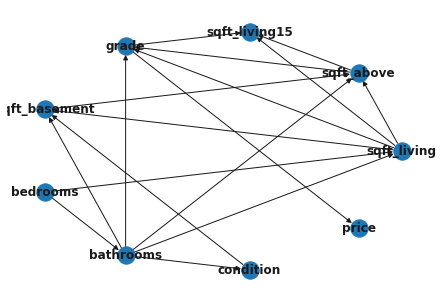

In [40]:
G_hill = nx.DiGraph()
G_hill.add_edges_from(bm_hill.edges())
pos = nx.layout.circular_layout(G_hill)
nx.draw(G_hill, pos, with_labels=True,font_weight='bold')
bm_hill = BayesianModel(bm_hill.edges())
bm_hill.fit(df_disc)
print(bm_hill.check_model())

In [41]:
print(f"K2 score of tree model {K2Score(df_disc).score(bm_hill):.2f}")
print(f"BIC score of tree model {BicScore(df_disc).score(bm_hill):.2f}")

K2 score of tree model -296848.39
BIC score of tree model -390945.57


# Tree Search

In [42]:
search = TreeSearch(df_disc, root_node="sqft_basement")
bm_tree = search.estimate()


  0%|          | 0/36.0 [00:00<?, ?it/s]
Building tree: 100%|██████████| 36/36.0 [00:00<00:00, 1102.20it/s]


True


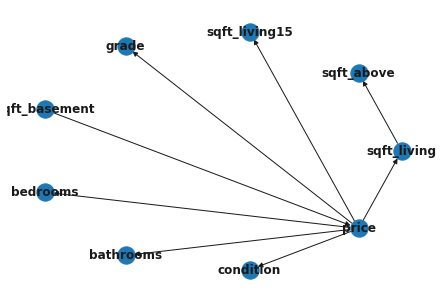

In [43]:
G_tree = nx.DiGraph()
G_tree.add_edges_from(bm_tree.edges())
nx.draw(G_tree, pos, with_labels=True,font_weight='bold')

bm_tree = BayesianModel(bm_tree.edges())
bm_tree.fit(df_disc)
print(bm_tree.check_model())

In [44]:
print(f"K2 score of tree model {K2Score(df_disc).score(bm_tree):.2f}")
print(f"BIC score of tree model {BicScore(df_disc).score(bm_tree):.2f}")

K2 score of tree model -355393.69
BIC score of tree model -855433.29


# Evaluation

In [45]:
from sklearn.model_selection import train_test_split

In [82]:
def fit_and_predict(graph, train, test):

    # bm = BayesianModel(graph.edges())
    # bm.fit(train)
    
    pred = graph.predict(test[predictors], n_jobs=12).values
    return pred

def collect_metrics(y_true, y_pred):
    metric = dict()
    
    metric['mae'] = metrics.mean_absolute_error(y_true, y_pred)
    metric['mse'] = metrics.mean_squared_error(y_true, y_pred)
    metric['mape'] = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    metric['r2'] = metrics.r2_score(y_true, y_pred)
    
    for name, value in metric.items():
        print(f'{name}: {value}')

In [58]:
def collect_stats(data, models, names, frac=0.1):
    test = data.sample(frac=frac, random_state=42)
    train = data.drop(test.index)
    
    stats = dict()
    for name, model in zip(names, models):
        print(name)
        pred = fit_and_predict(model, train, test)
        stats[name] = [pred]
        
        # collect_metrics(test[target], pred)
        # print('-'*30)
    
    return stats, test

In [59]:
pred, train = collect_stats(df_disc, [bm_custom, bm_tree, bm_hill], ('custom', 'tree', 'hill'))

  0%|          | 0/720 [00:00<?, ?it/s]

custom


  3%|▎         | 24/720 [00:00<00:03, 224.57it/s]

tree


  0%|          | 0/720 [00:00<?, ?it/s]

hill


100%|██████████| 720/720 [00:16<00:00, 43.62it/s]


In [64]:
test = data.sample(frac=0.1, random_state=42)

In [83]:
collect_metrics(test[target], pred['custom'][0].flatten())

mae: 176823.6947660954
mse: 74632975371.82076
mape: 33.27311949456841
r2: 0.43775415398424966


In [84]:
collect_metrics(test[target], pred['tree'][0].flatten())

mae: 190116.73784159333
mse: 81954186382.26633
mape: 35.52257394415667
r2: 0.3825999750449761


In [85]:
collect_metrics(test[target], pred['hill'][0].flatten())

mae: 179727.66419638722
mse: 78731745405.3937
mape: 35.785383809058835
r2: 0.40687616186790765
